In [1]:
pip install faker

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
from faker import Faker
import pandas as pd
import random
from datetime import datetime, timedelta
import os
import numpy as np

fake = Faker()

# Configuration
NUM_CUSTOMERS = 2000
NUM_PRODUCTS = 300
NUM_TRANSACTIONS = 30000
NUM_REVIEWS = 7500
START_DATE = datetime(2021, 1, 1)
END_DATE = datetime(2023, 1, 1)


def generate_dimensions():
    # Locations
    locations = [(i, fake.city(), fake.state(), fake.country())
                 for i in range(1, 501)]
    location_df = pd.DataFrame(locations, columns=['location_id', 'city', 'state', 'country'])
    location_df.to_csv('data/raw/dim_location.csv', index=False)

    # Categories
    categories = [
        (1, 'Electronics'), (2, 'Clothing'),
        (3, 'Home Appliances'), (4, 'Books'),
        (5, 'Sports'), (6, 'Beauty'),
        (7, 'Toys'), (8, 'Groceries')
    ]
    category_df = pd.DataFrame(categories, columns=['category_id', 'category_name'])
    category_df.to_csv('data/raw/dim_category.csv', index=False)

    # Products
    products = []
    for i in range(1, NUM_PRODUCTS + 1):
        products.append((
            i,
            fake.word().title() + " " + fake.word().title(),
            random.choice(categories)[0],
            round(random.uniform(5, 500), 2)
        ))

    # Introduce NaN values randomly into the `product_name` column
    product_df = pd.DataFrame(products, columns=['product_id', 'product_name', 'category_id', 'price'])
    product_df['product_name'] = product_df['product_name'].apply(
        lambda x: x if random.random() > 0.05 else None
    )

    # Introduce some duplicate products to simulate data issues
    product_df = pd.concat([product_df, product_df.sample(10)], ignore_index=True)

    # Introduce an outlier in the price column (e.g., price > 1000)
    product_df.loc[product_df.sample(5).index, 'price'] = random.randint(1000, 5000)

    product_df.to_csv('data/raw/dim_product.csv', index=False)

    # Customers
    customers = []
    for i in range(1, NUM_CUSTOMERS + 1):
        customers.append((
            i,
            fake.name(),
            fake.email(),
            fake.date_between(START_DATE, END_DATE),
            random.choice(locations)[0]
        ))

    customer_df = pd.DataFrame(customers, columns=['customer_id', 'name', 'email', 'signup_date', 'location_id'])

    # Introduce NaN values randomly into the `email` and `signup_date` columns
    customer_df['email'] = customer_df['email'].apply(
        lambda x: x if random.random() > 0.05 else None
    )
    customer_df['signup_date'] = customer_df['signup_date'].apply(
        lambda x: x if random.random() > 0.05 else None
    )

    # Introduce duplicate customers to simulate data issues
    customer_df = pd.concat([customer_df, customer_df.sample(5)], ignore_index=True)

    customer_df.to_csv('data/raw/dim_customer.csv', index=False)
def generate_facts():
    # Date dimension
    dates = []
    current_date = START_DATE
    while current_date <= END_DATE:
        dates.append((
            current_date.date(),
            current_date.day,
            current_date.month,
            (current_date.month - 1) // 3 + 1,
            current_date.year,
            current_date.weekday() + 1,
            current_date.weekday() >= 5
        ))
        current_date += timedelta(days=1)

    date_df = pd.DataFrame(dates, columns=['date_id', 'day', 'month', 'quarter', 'year', 'day_of_week', 'is_weekend'])
    date_df.to_csv('data/raw/dim_date.csv', index=False)

    # Transactions
    transactions = []
    products = pd.read_csv('data/raw/dim_product.csv')
    for i in range(1, NUM_TRANSACTIONS + 1):
        product = products.sample(1).iloc[0]
        transactions.append((
            i,
            random.randint(1, NUM_CUSTOMERS),
            product['product_id'],
            fake.date_between(START_DATE, END_DATE).isoformat(),
            round(product['price'] * random.uniform(0.8, 1.2) * random.randint(1, 5), 2),
            random.randint(1, 5)
        ))

    transaction_df = pd.DataFrame(transactions,
                                  columns=['transaction_id', 'customer_id', 'product_id', 'date_id', 'amount',
                                           'quantity'])

    # Introduce NaN values randomly into the `amount` column
    transaction_df['amount'] = transaction_df['amount'].apply(
        lambda x: x if random.random() > 0.05 else None
    )

    # Introduce duplicate transactions to simulate data issues
    transaction_df = pd.concat([transaction_df, transaction_df.sample(10)], ignore_index=True)

    # Introduce outliers in the `amount` column (e.g., extremely high values)
    transaction_df.loc[transaction_df.sample(5).index, 'amount'] = random.randint(1000, 10000)

    transaction_df.to_csv('data/raw/fact_transactions.csv', index=False)

    # Reviews
    reviews = []
    for i in range(1, NUM_REVIEWS + 1):
        transaction = random.choice(transactions)
        reviews.append((
            i,
            transaction[1],  # customer_id
            transaction[2],  # product_id
            (datetime.strptime(transaction[3], '%Y-%m-%d') + timedelta(days=random.randint(1, 30))).date(),
            random.randint(1, 5),
            fake.paragraph()
        ))

    review_df = pd.DataFrame(reviews,
                             columns=['review_id', 'customer_id', 'product_id', 'date_id', 'rating', 'review_text'])

    # Introduce NaN values randomly into the `review_text` column
    review_df['review_text'] = review_df['review_text'].apply(
        lambda x: x if random.random() > 0.05 else None
    )

    # Introduce duplicate reviews to simulate data issues
    review_df = pd.concat([review_df, review_df.sample(5)], ignore_index=True)

    review_df.to_csv('data/raw/fact_reviews.csv', index=False)


if __name__ == "__main__":
    os.makedirs('data/raw', exist_ok=True)
    generate_dimensions()
    generate_facts()
    print("Data generation complete! Files saved to data/raw/")


Data generation complete! Files saved to data/raw/


In [12]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev
from pyspark.sql.types import FloatType, DoubleType, IntegerType

# 1️⃣ Initialize Spark Session
spark = SparkSession.builder.appName("Data_Cleaning").getOrCreate()

# 2️⃣ List of CSV files
files = {
    "dim_category": "data/raw/dim_category.csv",
    "dim_customer": "data/raw/dim_customer.csv",
    "dim_date": "data/raw/dim_date.csv",
    "dim_location": "data/raw/dim_location.csv",
    "dim_product": "data/raw/dim_product.csv",
    "fact_reviews": "data/raw/fact_reviews.csv",
    "fact_transaction": "data/raw/fact_transactions.csv"
}

# 3️⃣ Load CSV Files
dataframes = {name: spark.read.csv(path, header=True, inferSchema=True) for name, path in files.items()}

# 4️⃣ Data Cleaning Functions
def clean_dataframe(df):
    # Remove rows with nulls in any column
    df = df.dropna(how='any')
    
    # Remove duplicates
    df = df.dropDuplicates()
    
    # Remove outliers (Z-score method for numeric columns)
    numeric_cols = [field.name for field in df.schema.fields if isinstance(field.dataType, (FloatType, DoubleType, IntegerType))]
    for col_name in numeric_cols:
        mean_val = df.select(mean(col(col_name))).collect()[0][0]
        stddev_val = df.select(stddev(col(col_name))).collect()[0][0]
        
        if mean_val is not None and stddev_val is not None and stddev_val != 0:
            df = df.filter((col(col_name) - mean_val) / stddev_val < 3)
    
    return df

# 5️⃣ Apply Cleaning Function
cleaned_dataframes = {name: clean_dataframe(df) for name, df in dataframes.items()}

# 6️⃣ Save Cleaned Data (optional)
for name, df in cleaned_dataframes.items():
    df.write.mode('overwrite').csv(f"data/refined/cleaned_{name}.csv", header=True)

# 7️⃣ Show Cleaned Data (optional)
for name, df in cleaned_dataframes.items():
    print(f"Cleaned Data for {name}:")
    df.show(5)

Cleaned Data for dim_category:
+-----------+-------------+
|category_id|category_name|
+-----------+-------------+
|          8|    Groceries|
|          2|     Clothing|
|          7|         Toys|
|          6|       Beauty|
|          4|        Books|
+-----------+-------------+
only showing top 5 rows

Cleaned Data for dim_customer:
+-----------+----------------+--------------------+-----------+-----------+
|customer_id|            name|               email|signup_date|location_id|
+-----------+----------------+--------------------+-----------+-----------+
|        800|   Donald Morgan|mooresamantha@exa...| 2022-11-05|        131|
|       1735| Dr. Holly Scott|rickywoods@exampl...| 2022-04-01|        157|
|        129|Pamela Rivera MD|victoria55@exampl...| 2021-05-22|        423|
|        469|    Michael Bass|   sward@example.org| 2021-03-01|         56|
|        484|     Tina Malone|vgoodwin@example.net| 2022-08-26|         19|
+-----------+----------------+--------------------+--

In [13]:
# Adding refined data into postgress
!pip install sqlalchemy 

In [14]:
!pip install psycopg2-binary


In [15]:
from sqlalchemy import create_engine
import pandas as pd

# Define PostgreSQL credentials
POSTGRES_USER = "postgres"
POSTGRES_PASSWORD = "password"  # Replace with actual password
POSTGRES_DB = "myapp"  # Replace with actual database name
POSTGRES_HOST = "db"  # Container name
POSTGRES_PORT = "5432"

# Create SQLAlchemy connection string
DATABASE_URL = f"postgresql://{POSTGRES_USER}:{POSTGRES_PASSWORD}@{POSTGRES_HOST}:{POSTGRES_PORT}/{POSTGRES_DB}"

# Establish connection
engine = create_engine(DATABASE_URL)

# Test connection
try:
    with engine.connect() as connection:
        print("✅ Successfully connected to PostgreSQL!")
except Exception as e:
    print("❌ Connection failed:", e)


✅ Successfully connected to PostgreSQL!


In [16]:
# Loading data into postgress
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("PostgresDataLoading") \
    .getOrCreate()

df_category = spark.read.csv("/home/jovyan/work/data/refined/cleaned_dim_category.csv", header=True, inferSchema=True)
df_customer = spark.read.csv("/home/jovyan/work/data/refined/cleaned_dim_customer.csv", header=True, inferSchema=True)
df_date = spark.read.csv("/home/jovyan/work/data/refined/cleaned_dim_date.csv", header=True, inferSchema=True)
df_location = spark.read.csv("/home/jovyan/work/data/refined/cleaned_dim_location.csv", header=True, inferSchema=True)
df_product = spark.read.csv("/home/jovyan/work/data/refined/cleaned_dim_product.csv", header=True, inferSchema=True)
df_fact_reviews = spark.read.csv("/home/jovyan/work/data/refined/cleaned_fact_reviews.csv", header=True, inferSchema=True)
df_fact_transaction = spark.read.csv("/home/jovyan/work/data/refined/cleaned_fact_transaction.csv", header=True, inferSchema=True)


def save_to_postgres(spark_df, table_name, engine):
    # Convert PySpark DataFrame to Pandas DataFrame
    pandas_df = spark_df.toPandas()
    
    # Save to PostgreSQL
    pandas_df.to_sql(table_name, engine, if_exists='replace', index=False)
    print(f"Saved {table_name} to PostgreSQL")


save_to_postgres(df_category, "dim_category", engine)
save_to_postgres(df_customer, "dim_customer", engine)
save_to_postgres(df_date, "dim_date", engine)
save_to_postgres(df_location, "dim_location", engine)
save_to_postgres(df_product, "dim_product", engine)
save_to_postgres(df_fact_reviews, "fact_reviews", engine)
save_to_postgres(df_fact_transaction, "fact_transaction", engine)
# # Store in PostgreSQL table
# df.to_sql("category", con=engine, if_exists="replace", index=False)

# print("✅ Data loaded successfully into PostgreSQL!")

Saved dim_category to PostgreSQL
Saved dim_customer to PostgreSQL
Saved dim_date to PostgreSQL
Saved dim_location to PostgreSQL
Saved dim_product to PostgreSQL
Saved fact_reviews to PostgreSQL
Saved fact_transaction to PostgreSQL


In [17]:
df = pd.read_sql("SELECT * FROM dim_customer;", engine)
df.head()

,customer_id,name,email,signup_date,location_id
0,800,Donald Morgan,mooresamantha@example.org,2022-11-05,131
1,1735,Dr. Holly Scott,rickywoods@example.com,2022-04-01,157
2,129,Pamela Rivera MD,victoria55@example.com,2021-05-22,423
3,469,Michael Bass,sward@example.org,2021-03-01,56
4,484,Tina Malone,vgoodwin@example.net,2022-08-26,19


/tmp/ipykernel_8872/3331689472.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_revenue', y='product_name', data=data, palette='viridis')


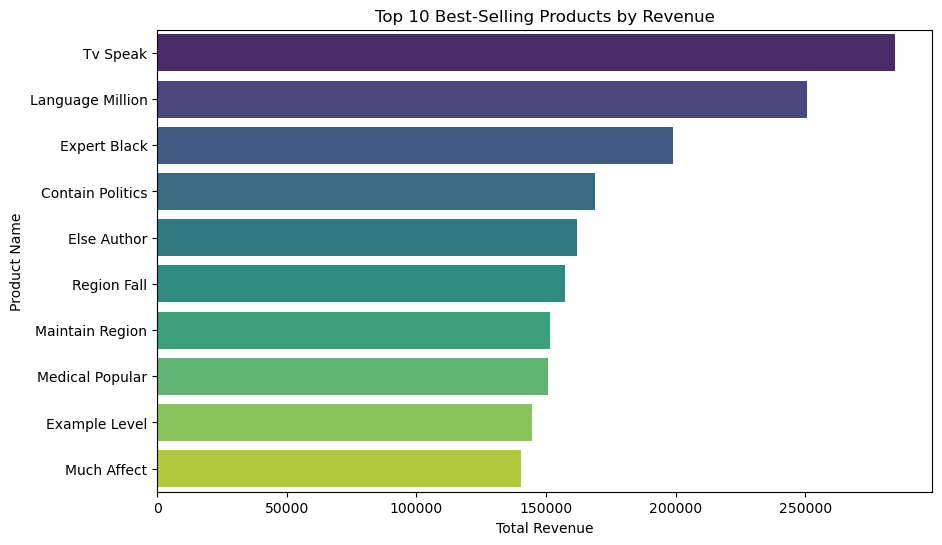

In [22]:
# Analysis

import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

def fetch_data(query):
    return pd.read_sql(query, engine)


# 1 Top 10 Top 10 Best-Selling Products by Revenue
query = """
SELECT p.product_name, SUM(t.amount) AS total_revenue
FROM fact_transaction t
JOIN dim_product p ON t.product_id = p.product_id
GROUP BY p.product_name
ORDER BY total_revenue DESC
LIMIT 10;
"""

data = fetch_data(query)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='total_revenue', y='product_name', data=data, palette='viridis')
plt.title('Top 10 Best-Selling Products by Revenue')
plt.xlabel('Total Revenue')
plt.ylabel('Product Name')
plt.show()

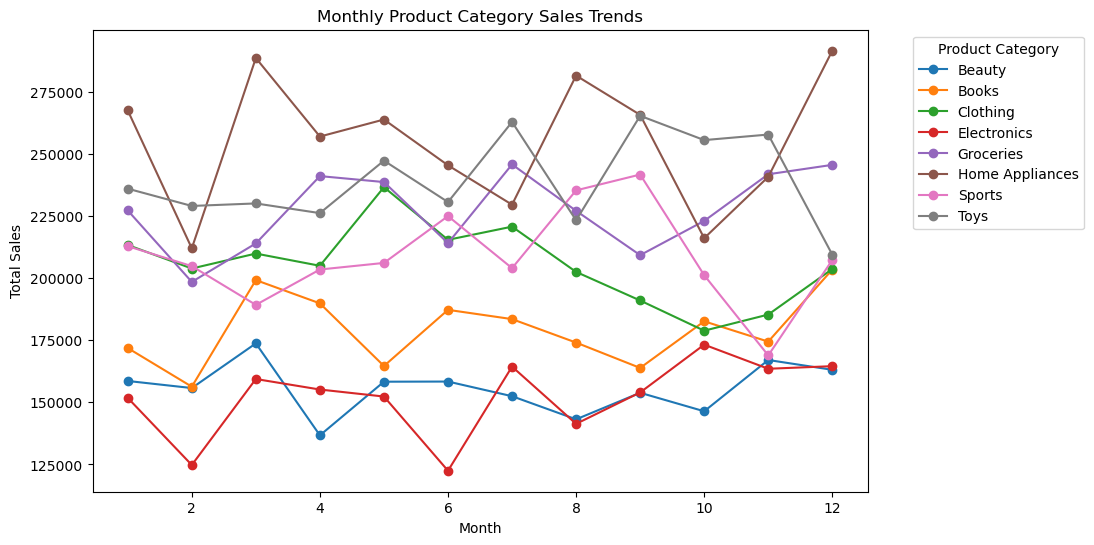

In [32]:
# Monthly Product Category Sales Trends
query = """
SELECT EXTRACT(MONTH FROM t.date_id) AS month, p.category_id, c.category_name, SUM(t.amount) AS total_sales
FROM fact_transaction t
JOIN dim_product p ON t.product_id = p.product_id
JOIN dim_category c ON p.category_id = c.category_id
GROUP BY month, p.category_id, c.category_name
ORDER BY month;
"""

data = fetch_data(query)

# Pivot data for plotting
sales_by_month_category = data.pivot(index='month', columns='category_name', values='total_sales')

# Plot
sales_by_month_category.plot(kind='line', figsize=(10, 6), marker='o')
plt.title('Monthly Product Category Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

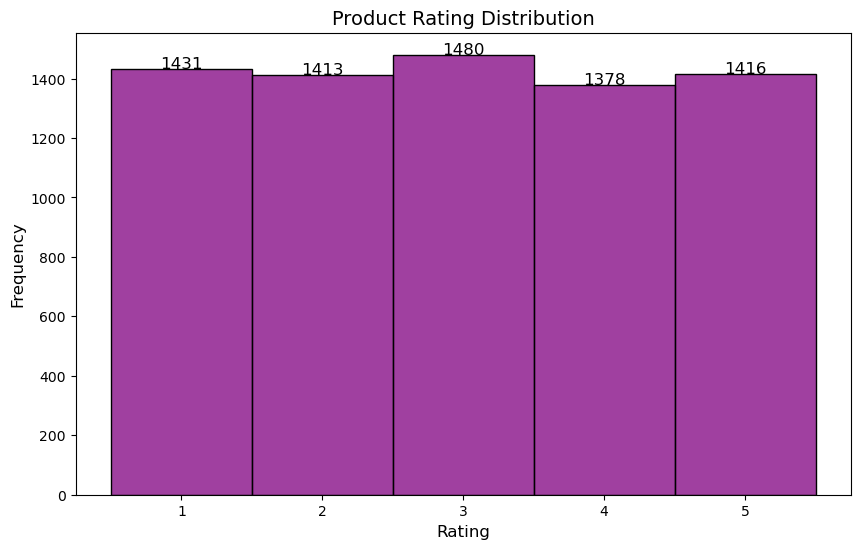

In [41]:
# Product Rating Distribution
query = """
SELECT r.rating
FROM fact_reviews r
WHERE r.rating BETWEEN 1 AND 5  -- Ensuring we only include valid ratings
"""

data = fetch_data(query)

# Plot
plt.figure(figsize=(10, 6))

# Plotting the histogram with adjusted bins and added kde
sns.histplot(data['rating'], bins=5, color='purple', discrete=True)

# Add a title and labels
plt.title('Product Rating Distribution', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Customizing the ticks for clarity
plt.xticks(ticks=[1, 2, 3, 4, 5], labels=['1', '2', '3', '4', '5'])

# Adding annotation for frequency
for i in range(1, 6):
    count = data[data['rating'] == i].shape[0]
    plt.text(i, count + 2, str(count), ha='center', color='black', fontsize=12)

plt.show()

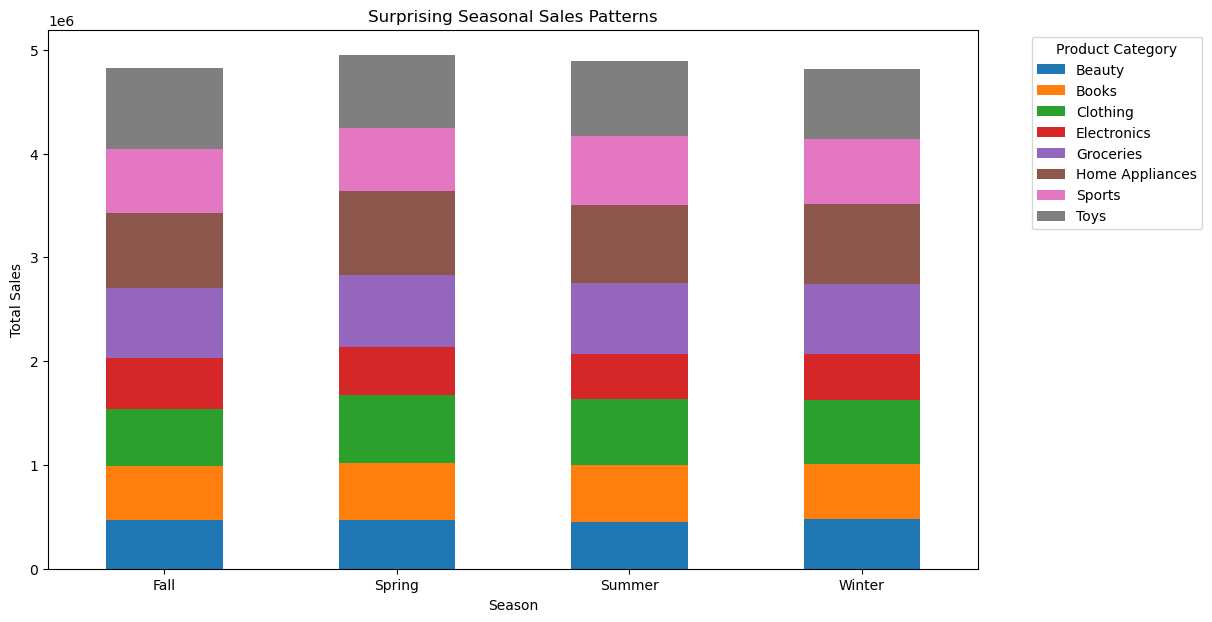

In [38]:
def fetch_data(query):
    return pd.read_sql(query, engine)


query = """
SELECT 
    CASE 
        WHEN EXTRACT(MONTH FROM t.date_id) IN (6, 7, 8) THEN 'Summer'
        WHEN EXTRACT(MONTH FROM t.date_id) IN (9, 10, 11) THEN 'Fall'
        WHEN EXTRACT(MONTH FROM t.date_id) IN (12, 1, 2) THEN 'Winter'
        WHEN EXTRACT(MONTH FROM t.date_id) IN (3, 4, 5) THEN 'Spring'
    END AS season,
    c.category_name, 
    SUM(t.amount) AS total_sales
FROM fact_transaction t
JOIN dim_product p ON t.product_id = p.product_id
JOIN dim_category c ON p.category_id = c.category_id
GROUP BY season, c.category_name
ORDER BY season, total_sales DESC;

"""

data = fetch_data(query)

# Pivot for plotting data by season
sales_by_season_category = data.pivot(index='season', columns='category_name', values='total_sales')

# Plot
sales_by_season_category.plot(kind='bar', figsize=(12, 7), stacked=True)
plt.title('Surprising Seasonal Sales Patterns')
plt.xlabel('Season')
plt.ylabel('Total Sales')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)  # Ensure season labels are horizontal
plt.show()

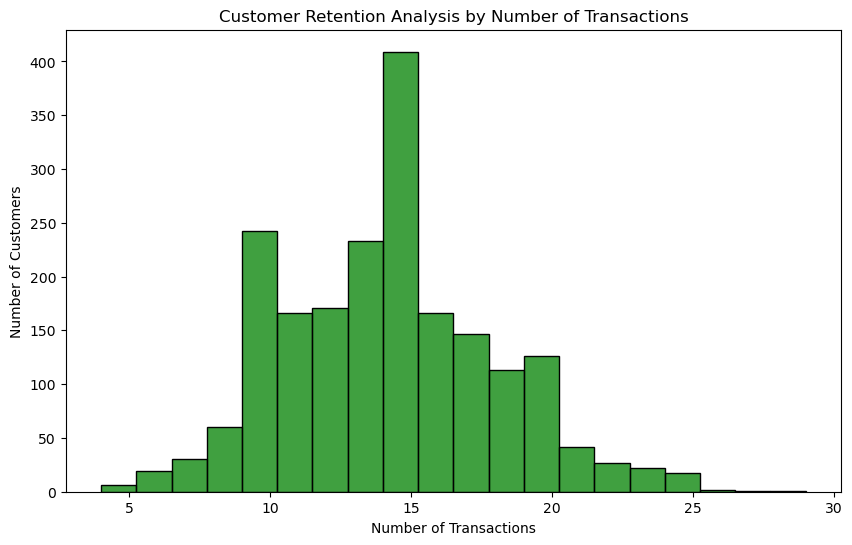

In [40]:
# Customer Retention by Number of Transactions
query = """
SELECT t.customer_id, COUNT(*) AS transaction_count
FROM fact_transaction t
GROUP BY t.customer_id
"""

data = fetch_data(query)

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(data['transaction_count'], bins=20, color='green')
plt.title('Customer Retention Analysis by Number of Transactions')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Customers')
plt.show()

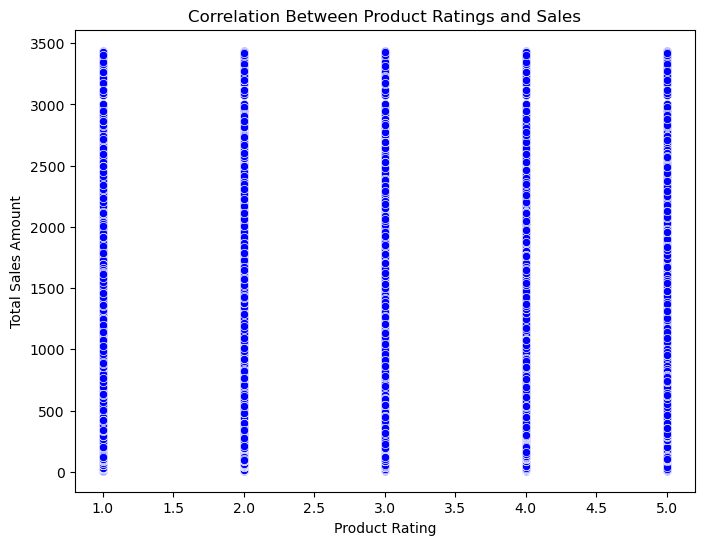

In [44]:
# Correlation Between Product Ratings and Sales


query = """
SELECT r.rating, t.amount
FROM fact_reviews r
JOIN fact_transaction t ON r.product_id = t.product_id
"""

data = fetch_data(query)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='rating', y='amount', data=data, color='blue')
plt.title('Correlation Between Product Ratings and Sales')
plt.xlabel('Product Rating')
plt.ylabel('Total Sales Amount')
plt.show()

/tmp/ipykernel_8872/979497562.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='review_count', y='product_name', data=data, palette='magma')


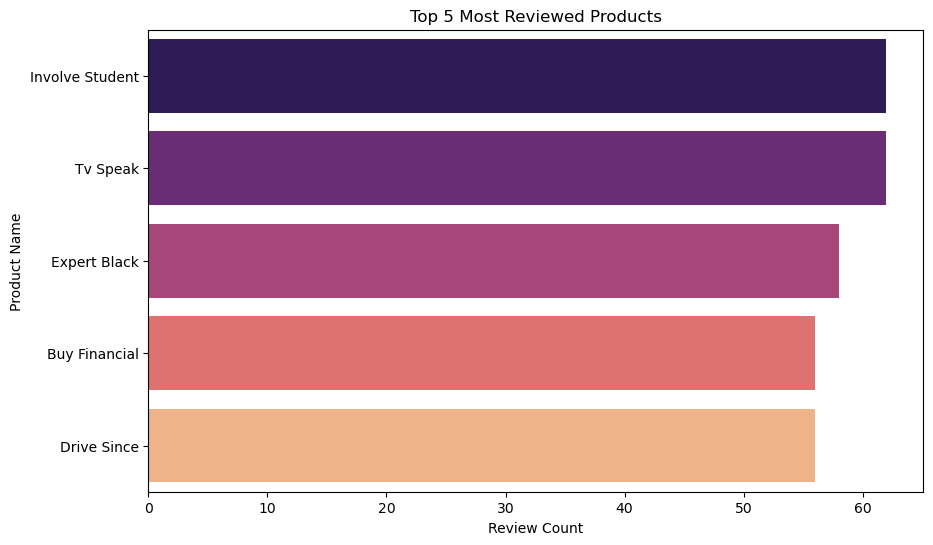

In [45]:
# Top 5 Most Reviewed Products


query = """
SELECT p.product_name, COUNT(r.review_id) AS review_count
FROM fact_reviews r
JOIN dim_product p ON r.product_id = p.product_id
GROUP BY p.product_name
ORDER BY review_count DESC
LIMIT 5;
"""

data = fetch_data(query)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='review_count', y='product_name', data=data, palette='magma')
plt.title('Top 5 Most Reviewed Products')
plt.xlabel('Review Count')
plt.ylabel('Product Name')
plt.show()

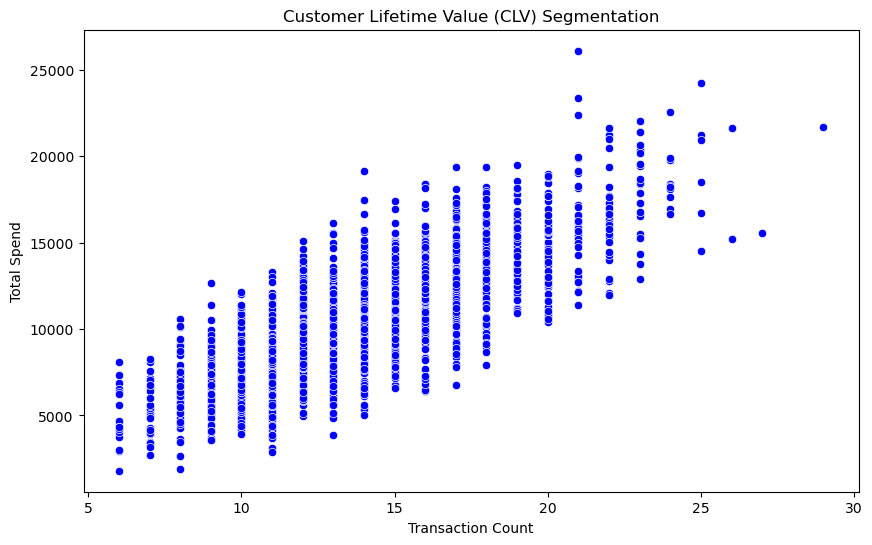

In [52]:
# Customer Lifetime Value (CLV) Segmentation Based on Transaction Count and Spend

# Analysis Insight: Identify customers with high customer lifetime value (CLV) based on transaction frequency and total spend. These customers may be more loyal or have a higher propensity to buy.


query = """
SELECT t.customer_id, COUNT(*) AS transaction_count, SUM(t.amount) AS total_spend
FROM fact_transaction t
GROUP BY t.customer_id
HAVING COUNT(*) > 5 AND SUM(t.amount) > 500
"""

data = fetch_data(query)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='transaction_count', y='total_spend', data=data, color='blue')
plt.title('Customer Lifetime Value (CLV) Segmentation')
plt.xlabel('Transaction Count')
plt.ylabel('Total Spend')
plt.show()